In [58]:
%matplotlib inline
import pandas as pd
pd.set_option('max_rows', 25)

In [72]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-72-1390d13c0cdd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [60]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
from pyxirr import xirr
import random

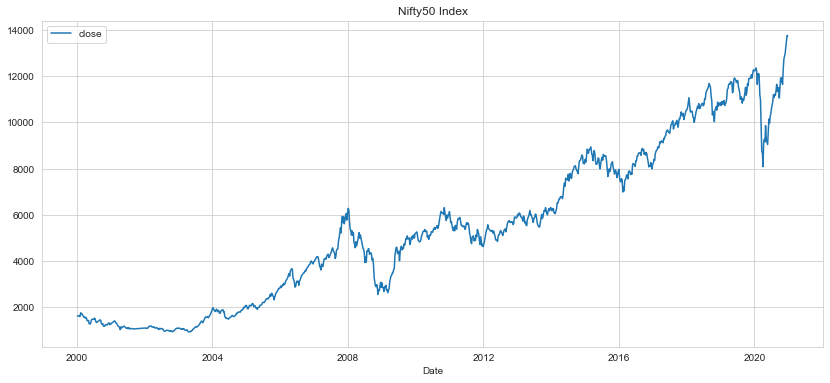

In [260]:
df_all = pd.read_csv("data_in_csv.csv", index_col=0, parse_dates=True)
df_all = df_all.rename(columns = {"Close": "close"}) #.loc[:"2019"]
df = df_all.copy(deep=True).loc[:"2020"]
#df
plt.figure(figsize=(14,6))
plt.title("Nifty50 Index")

sns.lineplot(data=df)
sns.set_style("whitegrid")

In [253]:
df["month_year"] = df.index.map(lambda i: i.year * 100 + i.month)
dfm_init = df.loc[df.groupby("month_year").close.apply(lambda rows: rows.index[0])]

In [254]:
def random_invest(holding_period = 1, plot = False):
    dfm_first = dfm_init.copy(deep=True)
    bought = False
    total_value = 1000000
    units = -1
    num_skip = 0

    for i in dfm_first.index:
        if num_skip > 0:
            num_skip = num_skip - 1
        else:
            current = dfm_first.loc[i]
            buy = bool(random.randint(0, 1))

            if buy:
                if not bought:    
                    units = total_value/current.close
                    bought = True
                    num_skip = holding_period - 1
            elif bought:
                total_value = units * current.close
                bought = False

        dfm_first.loc[i, "bought"] = bought
        dfm_first.loc[i, "units"] = units
        dfm_first.loc[i, "total_value"] = total_value
        dfm_first.loc[i, "num_skip"] = num_skip

    last_day = df_all.loc[df_all.index == df_all.index[-1]]
    last_close = last_day.close
    last_day.loc[last_day.index[0], "total_value"] = units * last_close[0]
    dfm_first = pd.concat([dfm_first, last_day])

    if plot:
        plt.figure(figsize=(14,6))
        plt.title("Portofolio")

        sns.lineplot(data=dfm_first.total_value)
        sns.set_style("whitegrid")
    
    return dfm_first

def calc_xirr(df_invest):
    df_one_day = df_invest.total_value.loc[(df_invest.index == df_invest.index[0]) | (df_invest.index == df_invest.index[-1])]
    df_one_day[0] = df_one_day[0] * -1
    od_xirr = xirr(df_one_day)
    return od_xirr

def calc_holding_period_return(df_invest):
    total_holding_period = len(df_invest[df_invest.bought == True])
    df_one_day = df_invest.total_value.loc[(df_invest.index == df_invest.index[0]) | (df_invest.index == df_invest.index[-1])]
    return ((df_one_day[1]/df_one_day[0]) - 1)/total_holding_period

In [255]:
periods = [1, 2, 6, 12, 24, 36, 60]
df_xirr = pd.DataFrame(columns=periods)
df_hpr = pd.DataFrame(columns=periods)

for i in range(100):
    xirrs = []
    hprs = []
    
    for period in periods:
        df_invest = random_invest(holding_period=period)
        xirrs.append(calc_xirr(df_invest))
        hprs.append(calc_holding_period_return(df_invest))
        
    df_xirr.loc[i] = xirrs
    df_hpr.loc[i] = hprs

/Users/vb/dev/python/notebooks/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/vb/dev/python/notebooks/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [256]:
(df_xirr * 100).describe().round(2)

,1,2,6,12,24,36,60
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,3.93,3.86,5.13,4.30,6.19,6.14,6.74
std,3.40,3.41,3.13,2.12,1.20,1.36,1.22
min,-3.13,-6.15,-1.33,-1.89,3.21,3.78,4.87
25%,1.67,1.28,3.30,3.23,5.58,5.22,5.87
50%,3.46,3.85,4.97,4.39,6.12,5.96,6.32
75%,6.25,6.27,7.47,5.71,7.04,6.95,7.43
max,12.81,11.98,12.90,10.85,9.48,9.95,11.02


In [257]:
(df_hpr * 12 * 100).describe().round(2)

,1,2,6,12,24,36,60
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,12.54,10.53,10.99,7.30,10.45,10.24,11.41
std,12.32,10.00,8.39,4.28,2.74,3.31,3.14
min,-6.04,-7.71,-1.72,-2.19,4.57,5.34,7.20
25%,4.04,2.58,5.56,4.81,8.76,7.99,9.15
50%,9.68,8.56,9.44,6.79,10.09,9.46,10.37
75%,19.21,16.41,15.51,9.79,12.29,11.85,12.82
max,59.33,43.21,38.64,25.88,18.99,20.81,24.22
